In [529]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline,make_pipeline
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import ComplementNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier,StackingClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix

In [437]:
data=pd.read_csv("./train.csv")

In [438]:
data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [439]:
data.shape

(318438, 18)

In [440]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [441]:
data['Ward_Type'].value_counts()

R    127947
Q    106165
S     77794
P      5046
T      1477
U         9
Name: Ward_Type, dtype: int64

In [442]:
data.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [443]:
data.nunique()
# case_id is unique for every record and hence could avoid that from further data analysis

case_id                              318438
Hospital_code                            32
Hospital_type_code                        7
City_Code_Hospital                       11
Hospital_region_code                      3
Available Extra Rooms in Hospital        18
Department                                5
Ward_Type                                 6
Ward_Facility_Code                        6
Bed Grade                                 4
patientid                             92017
City_Code_Patient                        37
Type of Admission                         3
Severity of Illness                       3
Visitors with Patient                    28
Age                                      10
Admission_Deposit                      7300
Stay                                     11
dtype: int64

In [444]:
analysis_dataset=data.copy(deep=True).drop('case_id',axis=1)

In [445]:
cat_columns=list(analysis_dataset.select_dtypes("object").columns)
num_columns=list(analysis_dataset.select_dtypes("number").columns)

# Univariate Analysis

array([[<AxesSubplot:title={'center':'Hospital_code'}>,
        <AxesSubplot:title={'center':'City_Code_Hospital'}>,
        <AxesSubplot:title={'center':'Available Extra Rooms in Hospital'}>],
       [<AxesSubplot:title={'center':'Bed Grade'}>,
        <AxesSubplot:title={'center':'patientid'}>,
        <AxesSubplot:title={'center':'City_Code_Patient'}>],
       [<AxesSubplot:title={'center':'Visitors with Patient'}>,
        <AxesSubplot:title={'center':'Admission_Deposit'}>,
        <AxesSubplot:>]], dtype=object)

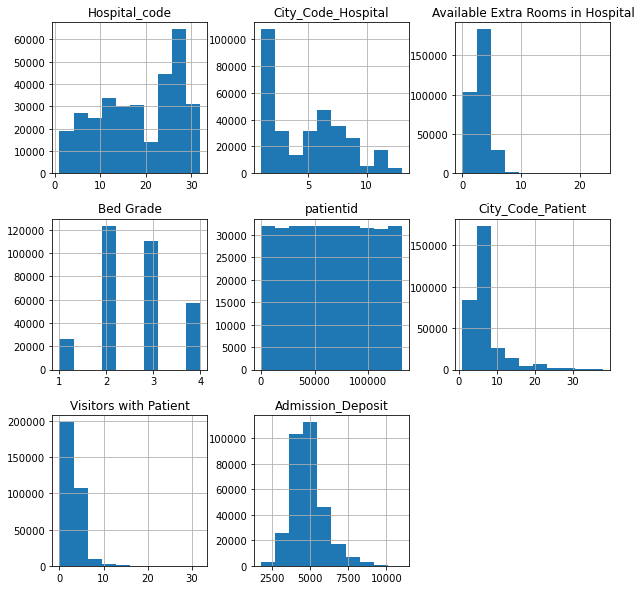

In [446]:
analysis_dataset.hist(column=num_columns,figsize=(10,10))
# Bed grade seems to have discrete values (only 4 discrete values)
# All distributions seems to be little skewed

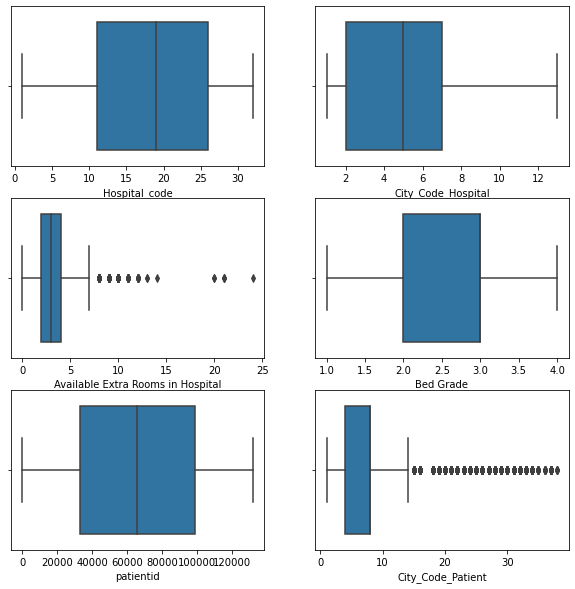

In [447]:
fig ,ax =plt.subplots(nrows=3,ncols=2,figsize=(10,10))
for column,axis in zip(num_columns,ax.flatten()):
    sns.boxplot(data=analysis_dataset,x=column,ax=axis)

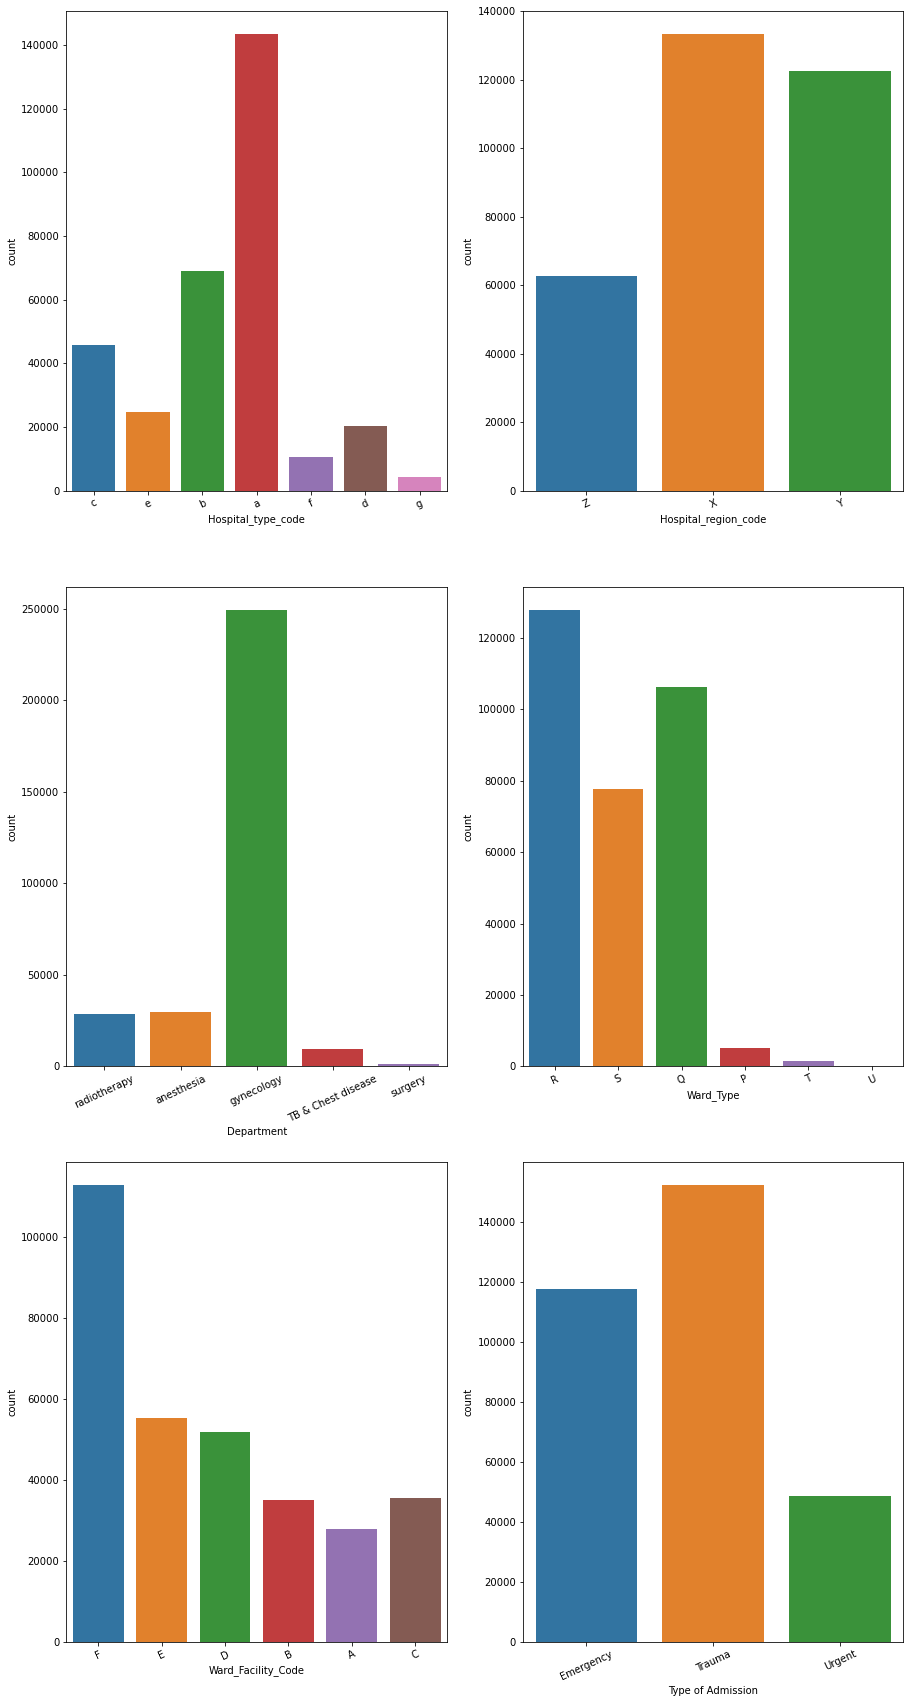

In [448]:
fig ,ax =plt.subplots(nrows=3,ncols=2,figsize=(15,30))
for column,axis in zip(cat_columns,ax.flatten()):
    sns.countplot(data=analysis_dataset,x=column,ax=axis)
    axis.set_xticklabels(axis.get_xticklabels(), rotation = 25)
    
# More patients are going to hospital type code 'a'
# Most number of patients reported from region X 
# Most of the patients to hospital are for gynaecology requirements
# Most of patients in the hospital occupying ward R,S,Q
# Most the patients are occupied in ward type code F
# Trauma cases are being reported the most followed by emergency

# Bivariate Analysis

## Stay vs Severity of illness

<AxesSubplot:xlabel='Stay'>

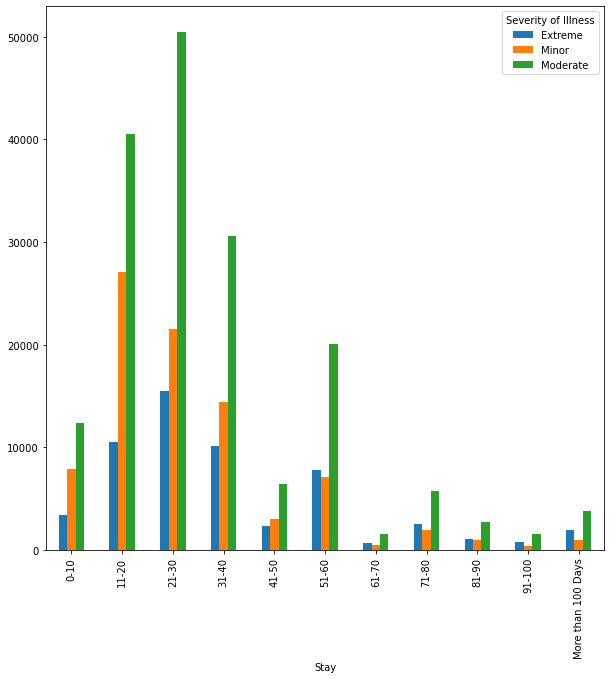

In [449]:
pd.crosstab(analysis_dataset['Stay'],analysis_dataset['Severity of Illness']).plot(kind="bar",figsize=(10,10))
#  For stay greater > 50 days , patients with extreme and moderate illness stayed for more days 
#  For stay greater < 50 days , patients with minor and moderate illness stayed more

## Stay vs Department

<AxesSubplot:xlabel='Stay'>

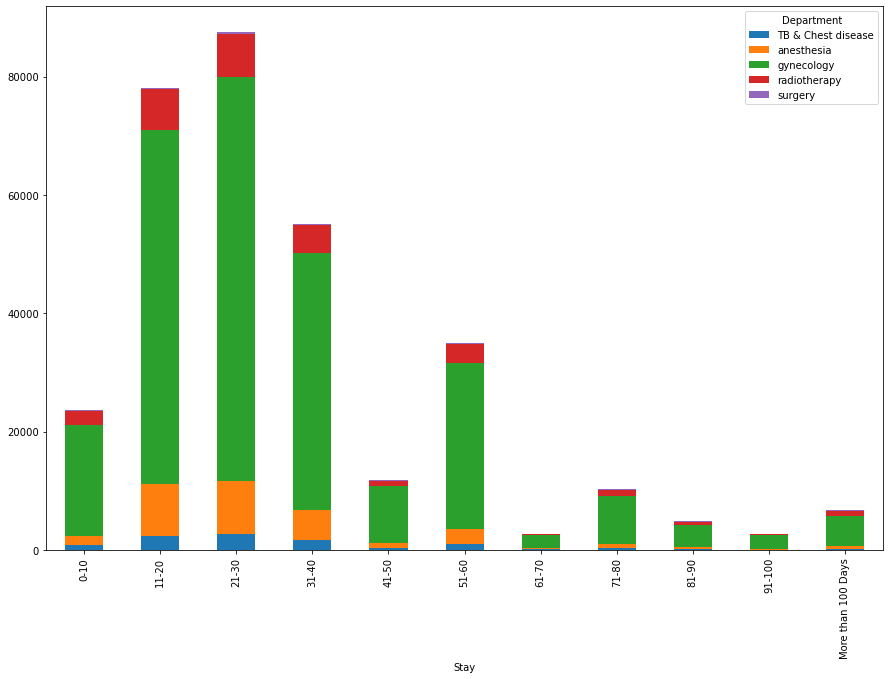

In [450]:
pd.crosstab(analysis_dataset['Stay'],analysis_dataset['Department']).plot(kind="bar",figsize=(15,10),stacked=True)
# Patients in gynaecology reported to stay more across age groups

## Stay vs Type of admission

<AxesSubplot:xlabel='Stay'>

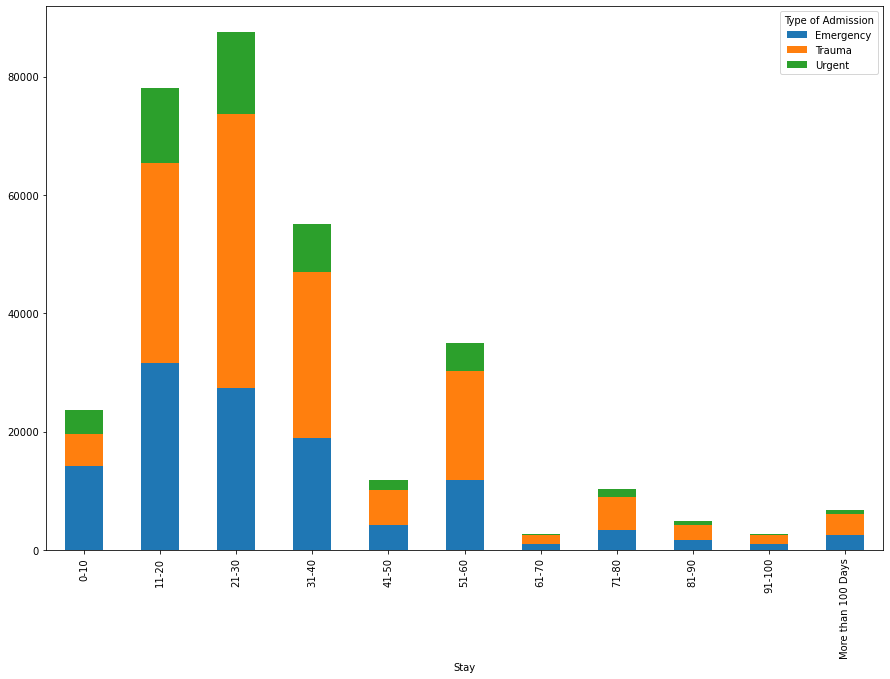

In [451]:
pd.crosstab(analysis_dataset['Stay'],analysis_dataset['Type of Admission']).plot(kind="bar",figsize=(15,10),stacked=True)
# Trauma patients tend to stay longer in hospital 

In [452]:
analysis_dataset.columns

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

<AxesSubplot:xlabel='Hospital_code'>

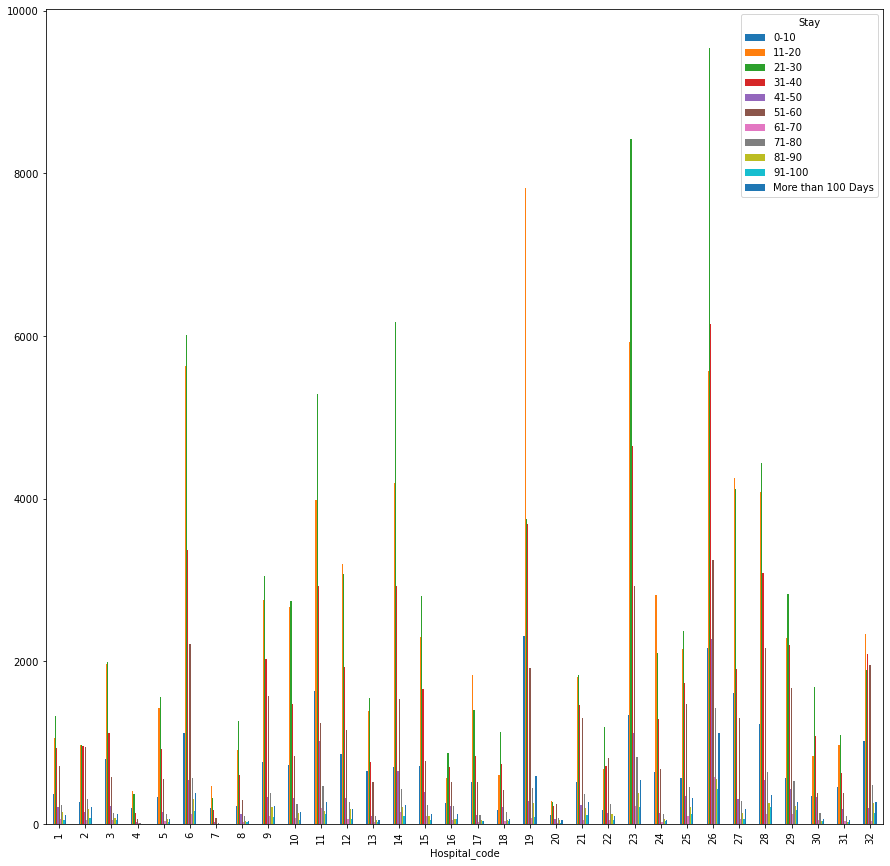

In [453]:
analysis_dataset.groupby(['Hospital_code','Stay'])['Hospital_code'].agg('count').unstack().plot(kind="bar",figsize=(15,15))

<AxesSubplot:xlabel='Stay'>

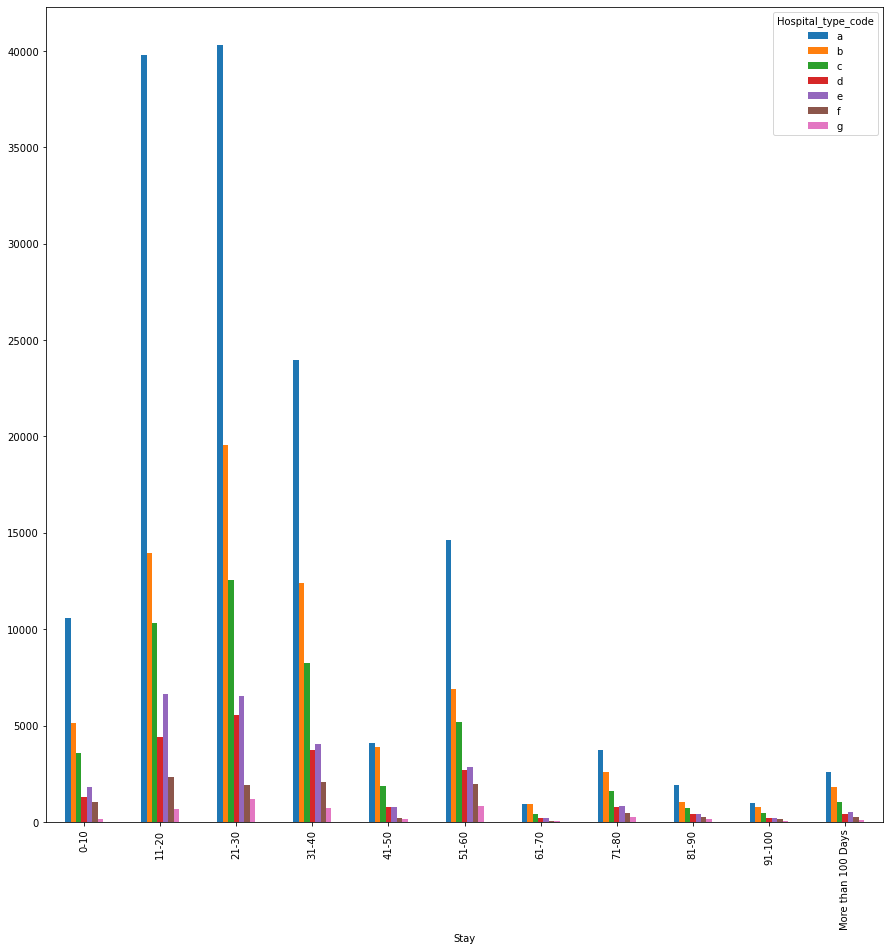

In [454]:
analysis_dataset.groupby(['Stay','Hospital_type_code'])['Stay'].agg('count').unstack().plot(kind="bar",figsize=(15,15))
# In Type A hospital people tend to stay more than other types

<AxesSubplot:xlabel='Stay'>

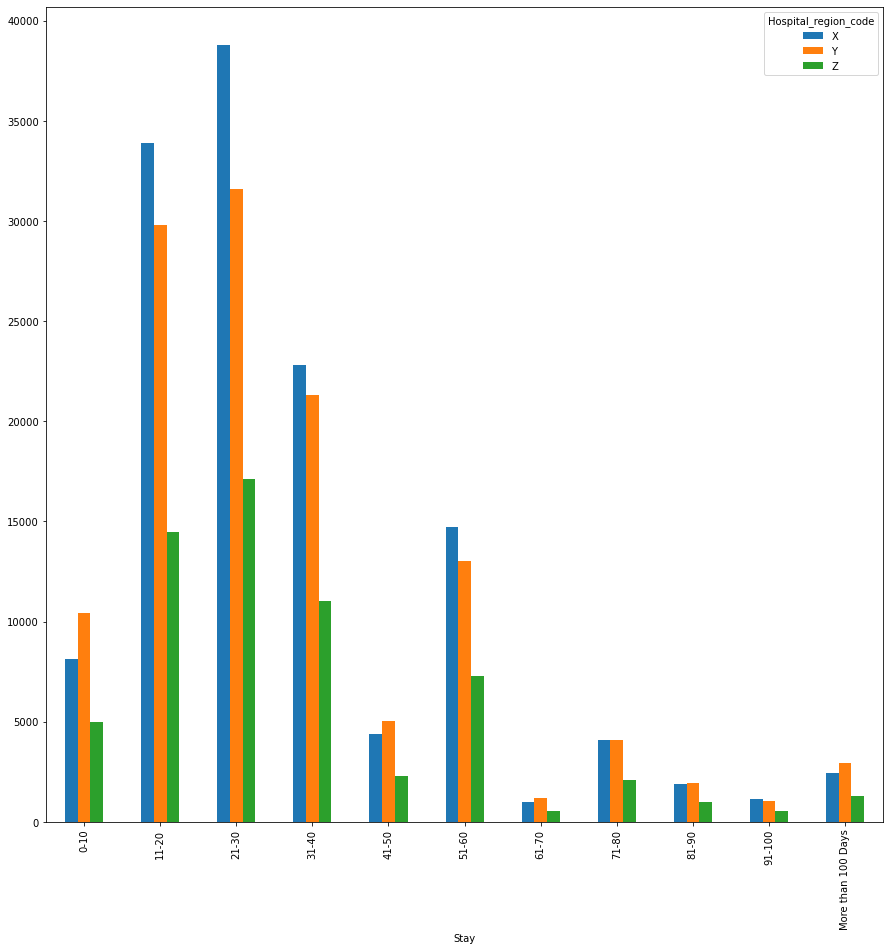

In [455]:
analysis_dataset.groupby(['Stay','Hospital_region_code'])['Stay'].agg('count').unstack().plot(kind="bar",figsize=(15,15))
# In Type A hospital people tend to stay more than other types

<AxesSubplot:xlabel='Stay'>

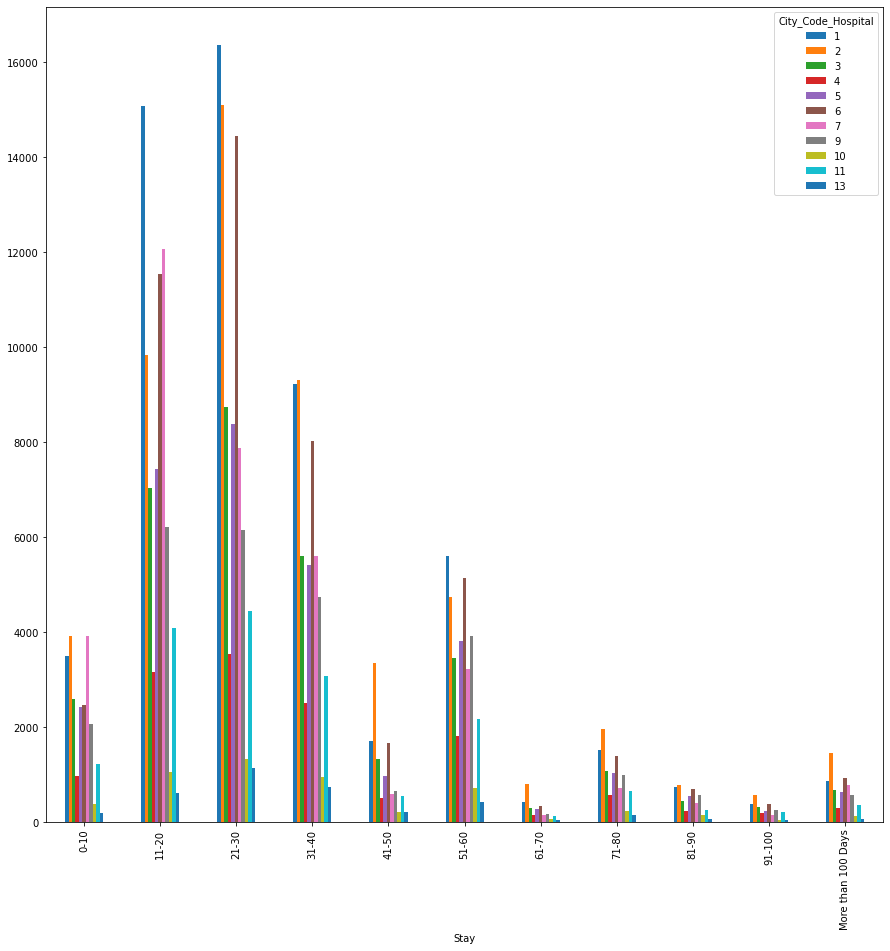

In [456]:
analysis_dataset.groupby(['Stay','City_Code_Hospital'])['Stay'].agg('count').unstack().plot(kind="bar",figsize=(15,15))

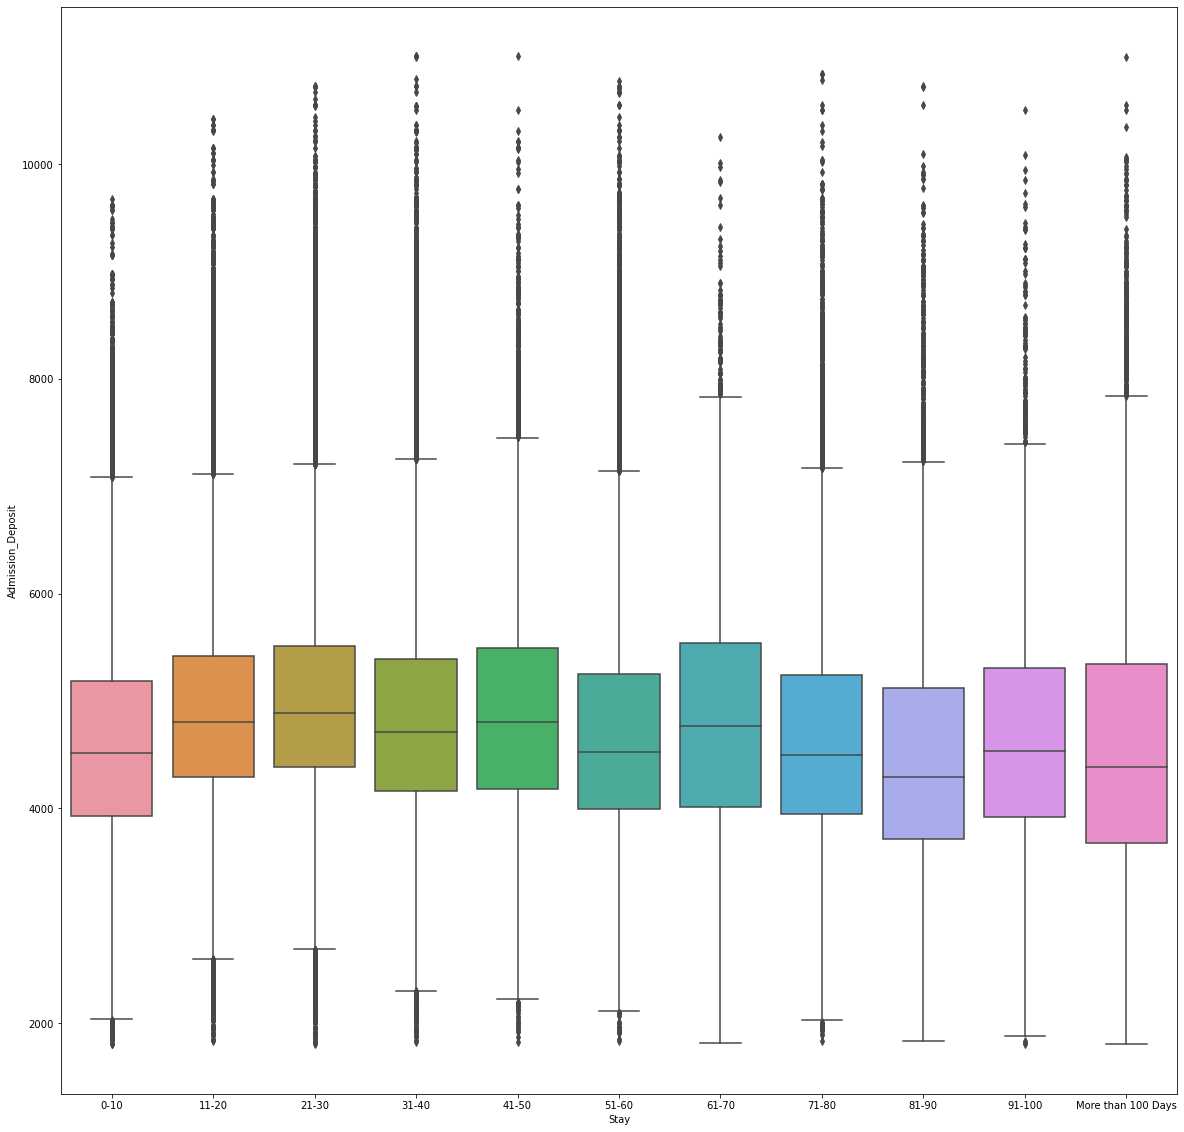

In [457]:
plt.figure(figsize=(20,20))
g=sns.boxplot(y='Admission_Deposit',x='Stay',data=analysis_dataset,order=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100', 'More than 100 Days'])
# Admission amount does not seem to have much impact on the stay

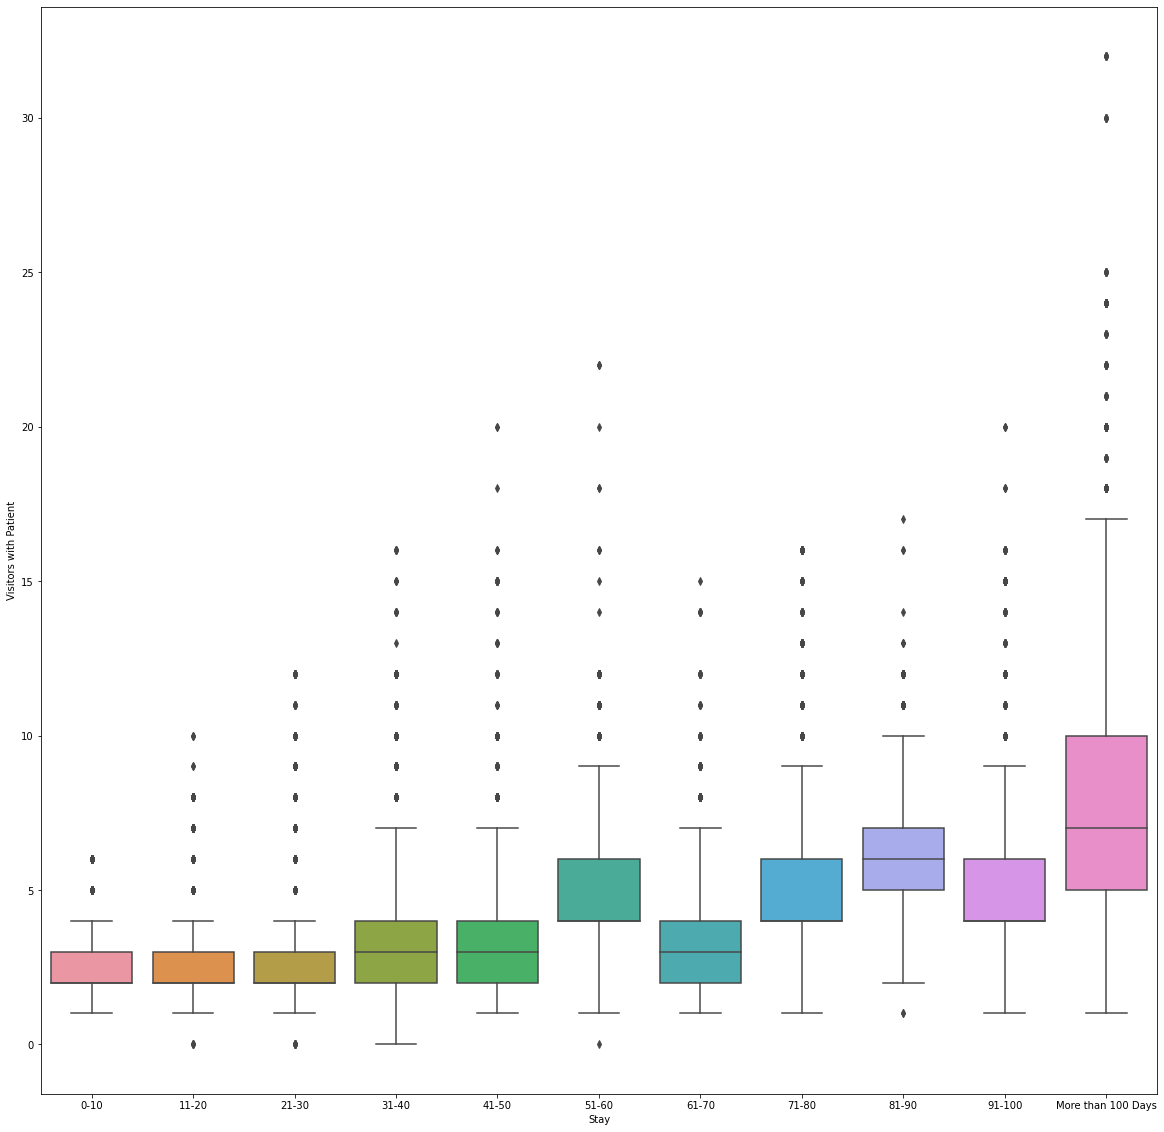

In [458]:
plt.figure(figsize=(20,20))
g=sns.boxplot(y='Visitors with Patient',x='Stay',data=analysis_dataset,order=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100', 'More than 100 Days'])

# Missing record analysis 

### Bed grade

In [459]:
analysis_dataset[analysis_dataset['Bed Grade'].isna()]['Ward_Type'].value_counts()
# Bed grade for patients are missing for the below ward facility code

R    72
Q    40
S     1
Name: Ward_Type, dtype: int64

In [460]:
analysis_dataset[analysis_dataset['Bed Grade'].isna()]['Hospital_code'].value_counts()
# Bed grade for patients are missing for the below hospital codes

6     109
7       3
19      1
Name: Hospital_code, dtype: int64

In [461]:
analysis_dataset[['Hospital_code','Ward_Type','Ward_Facility_Code','Bed Grade']].where(analysis_dataset['Hospital_code']==6).value_counts()
# Make more sense to replace with a bed grade that is available in the hospital

Hospital_code  Ward_Type  Ward_Facility_Code  Bed Grade
6.0            R          F                   2.0          4082
                                              3.0          3964
               Q          F                   3.0          3652
                                              2.0          3325
               R          F                   4.0          2014
               Q          F                   4.0          1881
               R          F                   1.0           751
               Q          F                   1.0           647
dtype: int64

In [462]:
analysis_dataset['Bed Grade']=analysis_dataset.groupby(['Hospital_code','Ward_Type','Ward_Facility_Code'])['Bed Grade'].transform(lambda x:  x.fillna(x.mode()[0]))

### City code of patient

In [463]:
patient_df=analysis_dataset[['patientid','City_Code_Patient']].value_counts().reset_index(name="Visit Count").drop(['Visit Count'],axis=1)

In [464]:
analysis_dataset.groupby(['patientid'])['City_Code_Patient'].transform(lambda x : x.fillna(x.mode()))
# Tried to fill details of the city code of patient using the info available in any other hospital . But did not help

0          7.0
1          7.0
2          7.0
3          7.0
4          7.0
          ... 
318433    23.0
318434     8.0
318435    10.0
318436     8.0
318437     8.0
Name: City_Code_Patient, Length: 318438, dtype: float64

In [429]:
analysis_dataset['City_Code_Patient']=np.where(analysis_dataset['City_Code_Patient'].isna(),analysis_dataset['City_Code_Hospital'],analysis_dataset['City_Code_Patient'])

# Preprocessing

In [465]:
cat_nom_columns=['Hospital_type_code',
 'Hospital_region_code',
 'Department',
 'Ward_Type',
 'Ward_Facility_Code',
 'Type of Admission']
cat_ord_columns=['Age','Severity of Illness']

In [495]:
data[num_columns]

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
0,8,3,3,2.0,31397,7.0,2,4911.0
1,2,5,2,2.0,31397,7.0,2,5954.0
2,10,1,2,2.0,31397,7.0,2,4745.0
3,26,2,2,2.0,31397,7.0,2,7272.0
4,26,2,2,2.0,31397,7.0,2,5558.0
...,...,...,...,...,...,...,...,...
318433,6,6,3,4.0,86499,23.0,3,4144.0
318434,24,1,2,4.0,325,8.0,4,6699.0
318435,7,4,3,4.0,125235,10.0,3,4235.0
318436,11,2,3,3.0,91081,8.0,5,3761.0


In [492]:
def get_ordinalEncodedData(X,y,col_name,categorylist):
    categories={}
    
    for ix,category in enumerate(categorylist):
        categories[str(category)]=ix
    encoding_mapping=[{'col':col_name , 'mapping': categories}]
    ord_Encoder=ce.ordinal.OrdinalEncoder(mapping=encoding_mapping)
    return ord_Encoder.fit_transform(X,y)

In [549]:
def preprocess_dataset(df):
    df.drop('case_id',axis=1,inplace=True)
    
    # Filling missing values 
    df['Bed Grade']=df.groupby(['Hospital_code','Ward_Type','Ward_Facility_Code'])['Bed Grade'].transform(lambda x:  x.fillna(x.mode()[0]))
    df['City_Code_Patient']=np.where(df['City_Code_Patient'].isna(),df['City_Code_Hospital'],df['City_Code_Patient'])
    
    # Encoding ordinal columns
    for col in cat_nom_columns:
        df[col]=get_ordinalEncodedData(df[col],df['Stay'],col,np.array(df[col].value_counts().index))
    df['Age']=get_ordinalEncodedData(df['Age'],df['Stay'],'Age', np.array(sorted(df['Age'].unique())))
    df['Severity of Illness']=df['Severity of Illness'].replace({'Minor':1,'Moderate':2,'Extreme':3})
    
    # Scaling of numerical columns
    rs=RobustScaler()
    for col in num_columns:  
        df[col]=rs.fit_transform(np.array(df[col]).reshape(-1,1))
    return df
    
    

In [550]:
preprocessed_dataset=preprocess_dataset(data.copy(deep=True))

In [551]:
X=preprocessed_dataset.drop('Stay',axis=1)
y=preprocessed_dataset['Stay']

In [552]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  float64
 1   Hospital_type_code                 318438 non-null  int32  
 2   City_Code_Hospital                 318438 non-null  float64
 3   Hospital_region_code               318438 non-null  int32  
 4   Available Extra Rooms in Hospital  318438 non-null  float64
 5   Department                         318438 non-null  int32  
 6   Ward_Type                          318438 non-null  int32  
 7   Ward_Facility_Code                 318438 non-null  int32  
 8   Bed Grade                          318438 non-null  float64
 9   patientid                          318438 non-null  float64
 10  City_Code_Patient                  318438 non-null  float64
 11  Type of Admission                  3184

# Train Test Split

In [531]:
def model_metrics(y_Actual,y_Pred):
    print(f"\n Classification Report : {classification_report(y_Actual,y_Pred)}")
    print(f"\n Confusion Matrix: {confusion_matrix(y_Actual,y_Pred)}")

In [540]:
def ExecuteModel(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=102)
    models = [
          ('Logistic Regression', LogisticRegression(random_state=102))#,
          ('KNN', KNeighborsClassifier()),
          ('Naive Bayes', ComplementNB())
    ]
#           ('Ridge', Ridge()),
#           ('RandomForest', RandomForestClassifier()),
          
        
    n_classes=len(y_train.unique())
    for name, model in models:
        clf = OneVsRestClassifier(model)
        y_score = clf.fit(X_train, y_train)
        y_pred=clf.predict(X_test)
        print('\n'+'-'*5 +str(name)+'-'*5+'\n')
        #print(f"\n cv score: {cross_val_score(clf, X_train, y_train, cv=5)}")
        model_metrics(y_test,y_pred)
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot of a ROC curve for a specific class
        for i in range(n_classes):
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()
            
            
        print('\n'+'-'*5 +'End of '+str(name)+'-'*5+'\n')
        
        

In [ ]:
ExecuteModel(X,y)

In [ ]:
# Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot of a ROC curve for a specific class
        for i in range(n_classes):
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.show()